# Fixing Further Study Verbatim

**Author: Andrew Chiu, RTO Performance Indicators Unit**

![Further study](../img/further_study.png)

A common path for VET students who do not enter the workforce is to go onto further study.

However, finding out where students go is difficult. 

They may not re-enter the VET system; they may go into higher education system. They may study in another state, or even overseas. 

Without data linkage to external data sets, the only way we can find out where students are going is to ask them via the Victorian Student Satisfaction Survey.

Earlier iterations of the Survey asked whether respondents went onto further study, and if so what the *level* of their course was, but we still did not have any clear indication of what the course was if they did not re-enter the Victorian VET system.

| Did you go onto further study? | If yes, what was the level of this course? | What is the name of this course? |
| :----------------------------: | :----------------------------------------: | :------------------------------: |
| Yes                            | Advanced Diploma                           | **?**                            |

This gap was plugged in the 2019 Student Satisfaction Survey, when we started to ask respondents who went onto further study to tell us the *name* of their course.

This was implemented as a free text field, and as a result is littered with errors.

** *This notebook explores some common mistakes in the further study free text field, and to create a series of functions to rectify them.* **

Rectifying these issues will provide us more confidence in picturing where students are going after their training.

## Import Python modules

Python, like R, can be supercharged by loading specific modules.

The following modules are great for *data analysis* and *natural language processing* (NLP).

In [64]:
%matplotlib inline
import re                           # Regular Expressions
import nltk                         # Natural Language ToolKit
import pandas as pd                 # Python Data Analysis Library
import numpy as np                  # Numerical Python
import matplotlib.pyplot as plt     # Visualisation

## Load data

Standard loading of csv data.

In [65]:
filePath = 'S:/RTOPI/Both Surveys/All Final Datasets/Datasets - 2019/StudentSurveys.csv'
df = pd.read_csv(filePath, encoding = 'ISO-8859-1')
df = df[df['SurveyYear'] == 'S2019']  

From the 2019 Survey, 28.2% of respondents reported that they have commenced another course or further study.


In [66]:
counts = df['s_fs_st'].value_counts()
props  = df['s_fs_st'].value_counts(normalize = True)
commenced = ['No', 'Yes', 'No answer', 'Unsure', 'Don\'t know / Refused']
pd.concat([counts, props], axis = 1, keys = ['counts', '%']).rename(index = {2: 'No', 1: 'Yes', -999: 'No answer', 4: 'Unsure', -99: 'Don\'t know / Refused'})

,counts,%
No,32929,0.610067
Yes,15231,0.282181
No answer,2933,0.054339
Unsure,2878,0.053320
Don't know / Refused,5,0.000093


### Select relevant fields

The Survey data is relatively large, but by no means unmanageable.

In [67]:
print("Number of columns: ", len(df.columns))
print("Number of rows:    ", len(df))

Number of columns:  276
Number of rows:     53976


But it's always a good idea to select only the fields required for analysis.

The fields that we need are:

* SurveyResponseID
* CourseID
* s_fs_lev
* s_fs_name_v

In [68]:
df = df[['SurveyResponseID', 'CourseID', 's_fs_lev', 's_fs_name_v']]
df[~pd.isna(df['s_fs_name_v'])].head(4)

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...
164265,S000091,CUA51015,7.0,Advanced Diploma of Screen and Media
164268,S000096,CUA20715,3.0,Certificate 3 Visual Art
164273,S000121,RGR40108,8.0,Equine science



#### Course level

It's customary to include the course level in the course name, but not everone has entered this information (see 'Equine science' above).

Luckily, the survey data includes the field *s_fs_lev*, which indicates the *level* of their further study. *s_fs_lev* is coded, so we need to add in the description. This will help to make sure the description is added to the verbatim if the respondent did not.

In [69]:
s_fs_lev_dict = {'s_fs_lev':          [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 'level_description': ['certificate i', 'certificate ii',
                                       'certificate iii', 'certificate iv',
                                       'vce or vcal', 'diploma',
                                       'advanced diploma', 'bachelor', 'higher than a degree']}
s_fs_lev_dict = pd.DataFrame(s_fs_lev_dict)  # Turn into data frame in order to left join
s_fs_lev_dict

,s_fs_lev,level_description
0,1,certificate i
1,2,certificate ii
2,3,certificate iii
3,4,certificate iv
4,5,vce or vcal
5,6,diploma
6,7,advanced diploma
7,8,bachelor
8,9,higher than a degree


Levels 5, 8 and 9 are ambiguous because they represent more than one type of course at the same level:

* 5 = vce **or** vcal
* 8 = bachelor **or** associate degree
* 9 = masters **or** PhD

For now, 8 is assigned "bachelor", as this is most common.

5 and 9 are ignored for the time being.

Now we can **merge the survey data with course level description**.

In [70]:
df = df[~pd.isna(df['s_fs_name_v'])]
df = pd.merge(df, s_fs_lev_dict, how = 'left')
df['s_fs_name_v'] = df['s_fs_name_v'].apply(lambda x: x.lower())
df.head(4)

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,level_description
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor
1,S000091,CUA51015,7.0,advanced diploma of screen and media,advanced diploma
2,S000096,CUA20715,3.0,certificate 3 visual art,certificate iii
3,S000121,RGR40108,8.0,equine science,bachelor


## Data exploration

Data exploration is an important part of data analytics. 

It's crucial to understand what the patterns are, and whether there are significant errors in the data which would impact the analysis.

A quick count of the raw verbatim reveals various types of common errors:

* course name without reference to the course level
* inconsistent representation of 'certificate'
* use of Arabic numbers instead of the standard Roman numbers
* course level after course name (i.e. early childhood and care *diploma*)

In [71]:
counts = df['s_fs_name_v'].value_counts()[df['s_fs_name_v'].value_counts() > 1].rename_axis('s_fs_name_v').reset_index(name = 'n')
counts

,s_fs_name_v,n
0,bachelor of nursing,319
1,diploma of nursing,226
2,diploma of community services,130
3,diploma of early childhood education and care,105
4,diploma of accounting,76
...,...,...
1213,criminal justice,2
1214,certificate 3 in pathology,2
1215,cert 3 in cabinet making,2
1216,certificate iv in eal,2


Most of the errors occur in low frequences (n), and the histogram below shows that there are a *lot* of course names with low counts.

**If we want to fix the problematic ones by inspecting them individually, this would take an unreasonable long time.**

Therefore, we need another approach.

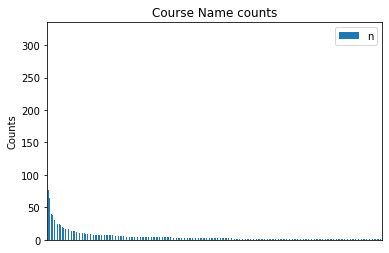

In [72]:
counts.plot(kind = 'bar')
x_axis = plt.axes().axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Course Name counts')
plt.ylabel('Counts')
plt.xlabel(xlabel = 'Course Name')
plt.show()

### Tokenize - splitting text into individual words

A standard approach to working with words is to 'tokenize' words, or splitting sentences into individual words.

This makes many things easier, such as identifying patterns, counting, and cleaning words.

In [73]:
# tokenized_df = df.copy() 
# tokenized_df['tokens'] = tokenized_df['s_fs_name_v'].apply(lambda x: nltk.word_tokenize(x))
# tokenized_df[['SurveyResponseID', 's_fs_name_v', 'tokens']].head()

In [74]:
tokenized_df = df.copy() 
tokenized_df['tokens'] = tokenized_df['s_fs_name_v'].apply(lambda x: re.split(' |/|/.', x))
tokenized_df[['SurveyResponseID', 's_fs_name_v', 'tokens']].head()

,SurveyResponseID,s_fs_name_v,tokens
0,S000019,associates degree of spatial science (surveyin...,"[associates, degree, of, spatial, science, (su..."
1,S000091,advanced diploma of screen and media,"[advanced, diploma, of, screen, and, media]"
2,S000096,certificate 3 visual art,"[certificate, 3, visual, art]"
3,S000121,equine science,"[equine, science]"
4,S000130,diploma in patisserie,"[diploma, in, patisserie]"


To operate on individual words, we need to convert the 'tokens' column into a column of individual *tokens*.

In [75]:
tokenized_df = tokenized_df.explode('tokens')
tokenized_df.head(9)

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,level_description,tokens
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,associates
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,degree
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,of
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,spatial
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,science
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,(surveying
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,major)
1,S000091,CUA51015,7.0,advanced diploma of screen and media,advanced diploma,advanced
1,S000091,CUA51015,7.0,advanced diploma of screen and media,advanced diploma,diploma


#### Package instructions into functions

The steps to prepare our data to this stage has so far been:

1. Left join course level description
2. Remove missing observations
3. Tokenize course verbatim
4. Convert to one-token-per-row

It's common practice to bundle a set of instructions that are used repeatedly or are complex into a sub-program.

As this may be used this year and future years, I think it would be good to package the above into a function, called *tokenize*.

In [76]:
def tokenize(data = df, id = 'SurveyResponseID', col = 's_fs_name_v'):
    
    data = data[~pd.isna(data[col])]

    s_fs_lev_dict = {'s_fs_lev':          [1, 2, 3, 4, 5, 6, 7, 8, 9],
                     'level_description': ['certificate i', 'certificate ii',
                                           'certificate iii', 'certificate iv',
                                           'vce or vcal', 'diploma',
                                           'advanced diploma', 'bachelor', 
                                           'higher than a degree']}
    s_fs_lev_dict = pd.DataFrame(s_fs_lev_dict)

    data = pd.merge(data, s_fs_lev_dict, how = 'left')
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub(r'\.', '', x))

    # tokenize
    # data['tokens'] = data[col].apply(lambda x: nltk.word_tokenize(x))
    data['tokens'] = data[col].apply(lambda x: re.split(' |/|/.', x))

    # convert to narrow data
    tokenized_df = data.explode('tokens')

    return(tokenized_df)

# tokenize(data = df)

In [77]:
tokenized_df.tokens.value_counts()

of          4679
in          3218
diploma     2998
and         2292
bachelor    2166
            ... 
cara           1
cyfi           1
(unsure)       1
oh&s.          1
(2             1
Name: tokens, Length: 4129, dtype: int64

### The Pareto Principle

The Pareto principle (AKA the 80/20 rule) states that roughly 80% of effects come from 20% of the causes.

In the case of further study verbatim, three types of mistakes account for most of the errors:

1. Course level misspelling
2. Course name misspelling
3. Missing or incorrect use of the words 'of' and 'in'

#### 1. Course level misspelling

**Bachelor degrees**

It's amazing how many people report going onto studying a bachelors degree, but spell 'bachelor' incorrectly.

Some common ways to misspell *bachelor* are identified below

In [78]:
tokens = tokenized_df['tokens'].value_counts().rename_axis('word').reset_index(name = 'n')
tokens[tokens['word'].str.contains('bach')].head(10)

,word,n
4,bachelor,2166
109,bachelors,64
439,bachelor's,11
497,bach,9
748,bachlor,5
1286,bacholor,2
1307,bachalor,2
1398,bacholar,2
1501,bacholer,2
1735,bacherlor,1


In [79]:
tokens[tokens['word'].str.contains('bech')]

,word,n
812,bechelor,4
1003,bechlor,3
2105,becholar,1
3003,bechalor,1


In [80]:
tokens[tokens['word'].str.contains('batch')]

,word,n
264,batchelor,21
1591,batch,2
3461,batchler,1


In [81]:
tokens[tokens['word'].str.contains('bauc')]

,word,n
2300,bauchor,1


In [82]:
tokens[tokens['word'].str.contains('bch')]

,word,n
1596,bchelor,2


In [83]:
tokens[tokens['word'].str.contains('bah')]

,word,n
1417,bahelor,2


The above demonstrates the 80/20 rule - a few *patterns*, if fixed, should fix most of the misspellings of the word "bachelor".

The fixes can be packaged into a function that takes in just a single argument, *string*, and returns a fixed version of the string.

The fixes are performed by identifying patterns using *regular expressions*.

Take the first line below as an example, where the code instructs to identify the pattern "^bac[a-z]*":

* The '^bac' instructs to look for where a string *starts* with 'bac'
* The [a-z]* instructs to look for where the string ends with any number of letters between a to z

In [135]:
def fix_bachelor(string):
    string = str(string)
    string = re.sub(pattern = "^bac[a-z]*", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bahelor$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^batch$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^batchler$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^bauchor$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bechalor$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bechlor$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^becholar$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^bchelor$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^bachelors$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bachelor's$", repl = "bachelor", string = string)

    return(string)

fix_bachelor("bachelor's")

'bachelor'

**Certificate**

There are many ways people spell the word "certificate".

Many variations are spelling errors, and others cutting short the 'certificate' into 'cert'. 

A perusal of these variations suggest that:

* Words that share the pattern 'cert#' should be split into 'certificate #' with a space.
* Words that begin with 'cert' should be replaced with the word 'certificate'

In [87]:
tokens[tokens['word'].str.contains('^cert')].head(10)

,word,n
5,certificate,2025
6,cert,1302
266,cert.,21
301,cert3,18
369,cert4,14
586,certificates,7
610,certification,7
760,certificat,5
815,certified,4
837,certiv,4


However, some words beginning with 'cert' appear legitimate, such as 'certified' and 'certification'. Looking at the original verbatim should help decide how to deal with these.

Below, the course names that contain 'certified' are in fact spelt correctly, such as 'certified practicing accountant (cpa)', and should therefore not be 'corrected'.

However, this instance points to another problem: the CPA is not a bachelor degree! CA and CPA courses are graduate diplomas, even though they generally require to have a bachelor degree.

In [88]:
tokenized_df[tokenized_df['tokens'].str.contains('^certified')]

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,level_description,tokens
1028,S013384,ICT60515,10.0,cisco certified networking associate,NaN,certified
1533,S019961,22253VIC,4.0,certified four,certificate iv,certified
2123,S027966,22257VIC,8.0,certified practicing accountant (cpa),bachelor,certified
4864,S063122,ICT40415,10.0,cisco certified entry networking technician,NaN,certified


Courses using the word 'certification', on the other hand, are generally just incorrect spelling of 'certificate'.

(Except the last one...)

In [89]:
tokenized_df[tokenized_df['tokens'].str.contains('^certification')]

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,level_description,tokens
954,S012460,22077VIC,4.0,certification 4 in auslan,certificate iv,certification
2480,S032801,CPC32413,10.0,level 1 irata international rope access certif...,NaN,certification
6555,S084010,HLT47315,4.0,certification iv in disability,certificate iv,certification
7929,S100740,CHC22015,3.0,certification iii health services assistance,certificate iii,certification
8503,S107816,BSB42015,8.0,bachelor of science. done concurrently with th...,bachelor,certification
10623,S133977,CHC30113,4.0,education support certification,certificate iv,certification
11144,S140338,BSB50615,8.0,ahri hr practicing certification - equivalent ...,bachelor,certification


Again, package this up into another function, and run some tests to make sure it's working.

In [90]:
def fix_certificate(string):
    string = str(string)
    if string != 'certified':
        string = re.sub(pattern = "^certi$", repl = "certificate i", string = string)
        string = re.sub(pattern = "^certii$", repl = "certificate ii", string = string)
        string = re.sub(pattern = "^certiii$", repl = "certificate iii", string = string)
        string = re.sub(pattern = "^certiv$", repl = "certificate iv", string = string)
        string = re.sub(pattern = "^cert1$", repl = "certificate i", string = string)
        string = re.sub(pattern = "^cert11$", repl = "certificate ii", string = string)
        string = re.sub(pattern = "^cert111$", repl = "certificate iii", string = string)
        string = re.sub(pattern = "^cert3$", repl = "certificate iii", string = string)
        string = re.sub(pattern = "^cert4$", repl = "certificate iv", string = string)
        string = re.sub(pattern = "^cirt$", repl = "certificate iv", string = string)

        # Convert Arabic to Roman numbers
        # (mainly for certificates)
        string = re.sub(pattern = "1", repl = "i", string = string)
        string = re.sub(pattern = "2", repl = "ii", string = string)
        string = re.sub(pattern = "3", repl = "iii", string = string)
        string = re.sub(pattern = "4", repl = "iv", string = string)

        # Convert English to Roman numbers
        # (mainly for certificates)
        string = re.sub(pattern = "one", repl = "i", string = string)
        string = re.sub(pattern = "two", repl = "ii", string = string)
        string = re.sub(pattern = "three", repl = "iii", string = string)
        string = re.sub(pattern = "four", repl = "iv", string = string)

        string = re.sub(pattern = "1v", repl = "iv", string = string)
        string = re.sub(pattern = "iiii", repl = "iv", string = string)

        # Remaining ways of spelling 'certificate'
        string = re.sub(pattern = "^cert[a-z]*", repl = "certificate", string = string)
        string = re.sub(pattern = "^cer$", repl = "certificate", string = string)

    return(string)

**Diplomas and advanced diplomas**

Sometimes, people are just out to get you... like 'diplomaofbuoldingandcons'.

For those unique cases, just ignore them for now.

In [97]:
tokens[tokens['word'].str.contains('^dip')]

,word,n
2,diploma,2998
162,dip,42
540,dip.,8
556,dipolma,8
1045,diplomat,3
1197,diploma.,2
1837,diploma-fire,1
1854,diplima,1
1917,diplomda,1
1942,diplomia,1


In [98]:
def fix_diploma(string):
    string = str(string)
    string = re.sub(pattern = "dip[a-z]*", repl = "diploma", string = string)

    return(string)

''

In the case of advanced diplomas, maybe just convert a few words, rather than pattern recognition:

* advance
* adv
* advancing
* advances
* advanved
* advans

In [99]:
tokens[tokens['word'].str.contains('^adv')]

,word,n
18,advanced,516
74,advance,93
297,adv,19
867,adv.,4
1096,advice,3
1616,advertising,2
1760,advans,1
1896,advisor),1
2953,advancing,1
3814,advanved,1


In [100]:
def fix_advanced(string):
    string = str(string)
    if string in ['advance', 'adv', 'advances', 'advanved', 'advans', 'advan']:
        return('advanced')
    else:
        return(string)

'advanced'

**Associate degree**

In [101]:
tokens[tokens['word'].str.contains('^asso[a-z]')]

,word,n
94,associate,76
390,associates,13
1645,associated,2


In [102]:
def fix_associate(string):
    string = str(string)
    string = re.sub(pattern = '^asso[a-z]', repl = 'associate', string = string)

    return(string)

### Other spelling errors

Similar to course level information, there are some high volume courses with various spelling.

The functions below address some of the more common mistakes.

In [119]:
def fix_parentheses(string):
    string = str(string)
    # string = re.sub(pattern = "\( ", repl = "(", string = string)
    # string = re.sub(pattern = " \)", repl = ")", string = string)
    
    return(string)

def fix_ecec(string):
    string = str(string)
    
    corrected = r'\1early childhood education and care'

    string = re.sub(r'(diploma of |certificate [i]* in )childcare$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )child care$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )early childhood$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )early childhood education$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )early childhood and care$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )early childhood and education$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )early childhood care and education$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )early education$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )ecec$', corrected, string = string)
    
    return(string)

def fix_aged_care(string):
    string = str(string)

    corrected =  r'\1aged care'

    string = re.sub(r'(diploma of |certificate [i]* in )agecare$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )agedcare$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )age care$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )aged care course$', corrected, string = string)
    
    return(string)

def fix_health_services(string):
    string = str(string)

    corrected = r'\1health services assistance'
    
    string = re.sub(r'(diploma of |certificate [i]* in )health service assistance$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )health service assistant$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )health services assistance$', corrected, string = string)

    return(string)

def fix_light_vehicle_mech(string):
    string = str(string)

    corrected = r'\1light vehicle mechanical technology'

    string = re.sub(r'(diploma of |certificate [i]* in )light vehicle mechanic$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )light vehicle mechanics$', corrected, string = string)

    return(string)

def fix_it(string):
    string = str(string)
    
    string = re.sub(r'(diploma of |certificate [i]* in )it$', r'\1information technology', string = string)

    return(string)

def fix_accounting_bookkeeping(string):
    string = str(string)

    corrected = r'\1accounting and bookkeeping'
    
    string = re.sub(r'(diploma of |certificate [i]* in )accountant and bookkeeping$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )accounting + bookkeeping$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )accounting and booking$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )accounting and bookkeeper$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )accounting and bookmaker$', corrected, string = string)

    return(string)

def fix_electrotech(string):
    string = str(string)
    
    corrected = r'\1electrotechnology'
    string = re.sub(r'(diploma of |certificate [i]* in )electro technology$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )electro tech$', corrected, string = string)
    string = re.sub(r'(diploma of |certificate [i]* in )electrotech$', corrected, string = string)

    return(string)

def fix_vet_nursing(string):
    string = str(string)
    
    string = re.sub(r'(diploma of |certificate [i]* in )vet nursing$', r'\1veterinary nursing', string = string)
    
    return(string)

**OF and IN**

One of the last steps is to address the way that course level information is standardised.

For certificates, it is customary to use "certificate x *in* y".

For diplomas and bachelors degrees, it is customary to use "diploma *of* y".

As there is a field indicating the level of the course, it's possible to compare whether the course level information is included in the verbatim or not. If it isn't, then add it in.

In [165]:
def add_cert_details(row):
    if (row['s_fs_lev'] in [1, 2, 3, 4]) & (row['level_desc_in_fixed'] == False):
        return(row['level_description'] + " in " + row['s_fs_name_v_fixed'])
    else:
        return(row['s_fs_name_v_fixed'])

def add_dip_details(row):
    if (row['s_fs_lev'] in [6, 7]) & (row['level_desc_in_fixed'] == False):
        return(row['level_description'] + " of " + row['s_fs_name_v_fixed'])
    else:
        return(row['s_fs_name_v_fixed'])

def bachelor_of(x):
    string = re.sub(r'(bachelor) in ([a-z]*)' , r'\1 of \2', str(x))
    return(string)

def diploma_of(x):
    # Change diploma IN to diploma OF
    string = re.sub(r'(diploma) in ([a-z]*)' , r'\1 of \2', str(x))

    # Add OF after diploma if missing
    if re.match('diploma', string):
        if re.match('diploma of', string = string):
            string = string
        else:
            string = re.sub('diploma', repl = 'diploma of', string = string)

    return(string) 


def certificate_in(x):
    # Change cert OF to cert IN
    string = re.sub(r'(certificate [a-z]*) of ([a-z]*)' , r'\1 in \2', str(x))

    # Add IN after cert if missing
    if re.match('certificate', string):
        if re.match(r'certificate ([iv]*) in', string):
            string = string
        else:
            string = re.sub(r'certificate ([iv]*)', repl = r'certificate \1 in', string = string)

    return(string)



## Putting it all together

To this stage, many small functions have been created, which can now be packaged together, piece by piece as needed!



In [167]:
def fix_fs_name_v(dataframe, id = 'SurveyResponseID', col = 's_fs_name_v'):
    # Tokenize s_fs_name_v column
    tokenized_df = tokenize(dataframe, id = id, col = col)

    # Fix words
    tokenized_df['tokens2'] = tokenized_df['tokens'].apply(fix_bachelor)
    tokenized_df['tokens2'] = tokenized_df['tokens2'].apply(fix_certificate)
    tokenized_df['tokens2'] = tokenized_df['tokens2'].apply(fix_diploma)
    tokenized_df['tokens2'] = tokenized_df['tokens2'].apply(fix_advanced)
    tokenized_df['tokens2'] = tokenized_df['tokens2'].apply(fix_associate)

    # Join tokens together again
    df_fixed = tokenized_df.groupby([id, col, 'level_description'])['tokens2'].apply(' '.join).reset_index(name = 's_fs_name_v_fixed')

    
    # Join df_fixed and original df
    df_fixed = pd.merge(dataframe, df_fixed)

    # Flag whether qualification information is already in the fixed string
    # df_fixed['level_description'] = df_fixed['level_description'].astype('string')
    # df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].astype('str')
    df_fixed['level_desc_in_fixed'] = df_fixed.apply(lambda x: x.level_description in x.s_fs_name_v_fixed, axis = 1)

    # Add certificate and diploma info
    df_fixed['s_fs_name_v_fixed'] = df_fixed.apply(lambda x: add_cert_details(x), axis = 1)
    df_fixed['s_fs_name_v_fixed'] = df_fixed.apply(lambda x: add_dip_details(x), axis = 1)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(diploma_of)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(bachelor_of)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(certificate_in)

    # Fix common misspellings
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_ecec)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_aged_care)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_health_services)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_light_vehicle_mech)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_it)
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_accounting_bookkeeping)

    return(df_fixed)

So now we have a function that takes in a data frame, an 'id' column which can be used to join back to the original data set, and the column name in the data frame that contains the further study verbatim.

This design makes it easier even for non-Python users to pick up and use on future data sets.

In [168]:
temp = fix_fs_name_v(dataframe = df, id = 'SurveyResponseID', col = 's_fs_name_v')
temp = pd.merge(df, temp)
temp

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,level_description,s_fs_name_v_fixed,level_desc_in_fixed
0,S000019,CPP50116,8.0,associates degree of spatial science (surveyin...,bachelor,associateiates degree of spatial science (surv...,False
1,S000091,CUA51015,7.0,advanced diploma of screen and media,advanced diploma,advanced diploma of screen and media,True
2,S000096,CUA20715,3.0,certificate 3 visual art,certificate iii,certificate iii in visual art,True
3,S000121,RGR40108,8.0,equine science,bachelor,equine science,False
4,S000130,SIT40716,6.0,diploma in patisserie,diploma,diploma of patisserie,True
...,...,...,...,...,...,...,...
12205,S165505,FNS50615,6.0,diploma of financial planning,diploma,diploma of financial planning,True
12206,S165509,AHC41016,4.0,agriculture,certificate iv,certificate iv in agriculture,False
12207,S165510,HLT51612,8.0,bachelor of nursing,bachelor,bachelor of nursing,True
12208,S165523,22077VIC,4.0,certificate 4 in auslan,certificate iv,certificate iv in auslan,True


## Results


### Early Childhood Education and Care

Before

In [122]:
df[df['CourseID'] == 'CHC30113']['s_fs_name_v'].value_counts().head(15).reset_index(name = 'n').head(15)

,index,n
0,diploma of early childhood education and care,71
1,diploma in early childhood education and care,52
2,diploma in early childhood education,15
3,diploma of early childhood education,12
4,education support,11
5,diploma in childcare,10
6,diploma in early childhood,9
7,early childhood education and care,7
8,diploma in child care,6
9,diploma in early childhood and care,6


After

In [158]:
temp[temp['CourseID'] == "CHC30113"]['s_fs_name_v_fixed'].value_counts().reset_index(name = 'n').head(15)

,index,n
0,diploma of early childhood education and care,222
1,certificate iv in education support,14
2,diploma of nursing,7
3,certificate iii in education support,5
4,certificate ii in community services,3
5,bachelor of education,3
6,diploma of,3
7,certificate iii in aged care,3
8,childcare diploma,3
9,diploma of early childhood learning,2


### Nursing
Before

In [138]:
df[df['CourseID'] == 'HLT54115']['s_fs_name_v'].value_counts().head(15).reset_index(name = 'n').head(15)

,index,n
0,bachelor of nursing,141
1,diploma of nursing,24
2,nursing,5
3,bachelors of nursing,4
4,early childhood education and care,3
5,degree in nursing,3
6,bachelor of dermal sciences,2
7,diploma of community services,2
8,bachelor of education,2
9,diploma in nursing,2


After

In [159]:
temp[temp['CourseID'] == "HLT54115"]['s_fs_name_v_fixed'].value_counts().reset_index(name = 'n').head(15)

,index,n
0,bachelor of nursing,151
1,diploma of nursing,30
2,degree in nursing,3
3,diploma of paramedical science,3
4,certificate iii in early childhood education a...,3
5,diploma of early childhood education and care,3
6,diploma of paramedicine,2
7,bachelor of education,2
8,biomedical science,2
9,diploma of justice,2


### Cyber Security
Before

In [112]:
df[df['CourseID'] == '22334VIC']['s_fs_name_v'].value_counts().head(15).reset_index(name = 'n').head(5)

,index,n
0,cyber security,2
1,pentest with kali-linux,1
2,"the ""know your gizmo"" day class at the cae in ...",1
3,cert. iv in information technlology,1
4,cyber security course but in a better tafe.,1


After

In [160]:
temp[temp['CourseID'] == "22334VIC"]['s_fs_name_v_fixed'].value_counts().reset_index(name = 'n').head(5)

,index,n
0,advanced diploma of cyber security,3
1,bachelor degree in cyber security at deakin un...,1
2,certificate iv in information technology neiir...,1
3,advanced diploma of cyber security at box hill...,1
4,certificate iv in tae,1


### Agriculture
Before

In [161]:
df[df['CourseID'] == 'AHC20116']['s_fs_name_v'].value_counts().head(15).reset_index(name = 'n').head(5)

,index,n
0,doctor of veterinary medicine,11
1,certificate 3 in agriculture,7
2,certificate iii in agriculture,3
3,doctor of veterinary medicine (dvm),2
4,cert 3 in agriculture ag schools wodonga tafe,1


After

In [162]:
temp[temp['CourseID'] == "AHC20116"]['s_fs_name_v_fixed'].value_counts().reset_index(name = 'n').head(5)

,index,n
0,certificate iii in agriculture,12
1,doctor of veterinary medicine,11
2,doctor of veterinary medicine (dvm),2
3,certificate iv in agriculture,2
4,certificate iii in agriculture,1


## Electrotechnology (Career Start)
Before

In [116]:
df[df['CourseID'] == 'UEE22011']['s_fs_name_v'].value_counts().head(15).reset_index(name = 'n').head(5)

,index,n
0,electrotechnology,10
1,certificate iii in electrotechnology,10
2,certificate 3 in electrotechnology,9
3,cert iii electrotechnology,5
4,cert iii in electrotechnology,4


After

In [169]:
temp[temp['CourseID'] == "UEE22011"]['s_fs_name_v_fixed'].value_counts().reset_index(name = 'n').head(5)

,index,n
0,certificate iii in electrotechnology,46
1,certificate iii in electrotechnology electrician,5
2,electrotechnology certificate iii,4
3,certificate iii in electro technology,4
4,certificate iii in electrotechnogy,2
